In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
# # Generator
# class Generator(nn.Module):
#     def __init__(self, latent_dim=100):
#         super(Generator, self).__init__()
        
#         self.model = nn.Sequential(
#             nn.Linear(latent_dim, 128 * 7 * 7),
#             nn.ReLU(),
#             nn.Unflatten(1, (128, 7, 7)),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(128, 128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128, momentum=0.78),
#             nn.ReLU(),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(128, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64, momentum=0.78),
#             nn.ReLU(),
#             nn.Conv2d(64, 1, kernel_size=3, padding=1),
#             nn.Tanh()  # Output range [-1, 1]
#         )

#     def forward(self, z):
#         img = self.model(z)
#         return img


# # Discriminator
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
        
#         self.model = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.25),
#             nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
#             nn.ZeroPad2d((0, 1, 0, 1)),
#             nn.BatchNorm2d(64, momentum=0.82),
#             nn.LeakyReLU(0.25),
#             nn.Dropout(0.25),
#             nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(128, momentum=0.82),
#             nn.LeakyReLU(0.2),
#             nn.Dropout(0.25),
#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(256, momentum=0.8),
#             nn.LeakyReLU(0.25),
#             nn.Dropout(0.25),
#             nn.Flatten(),
#             nn.Linear(256 * 4 * 4, 1),  # Adjusted for feature map size
#             nn.Sigmoid()
#         )

#     def forward(self, img):
#         validity = self.model(img)
#         return validity


In [17]:
# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64 * 7 * 7),  # Reduced initial size
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),  # Reduced channels
            nn.BatchNorm2d(32, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),  # Directly output single-channel (grayscale)
            nn.Tanh()  # Output range [-1, 1]
        )

    def forward(self, z):
        img = self.model(z)
        return img


# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64, momentum=0.82),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128, momentum=0.8),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 1),  # Adjusted for feature map size
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity


In [18]:
# Data loading and transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1] for Tanh activation
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [22]:
# Hyperparameters
latent_dim = 100
learning_rate = 0.0002
num_epochs = 10

# Initialize generator and discriminator
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))


In [23]:
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        
        # Ground truths and labels
        real_labels = torch.ones(imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(imgs.size(0), 1).to(device)

        # Train Generator
        optimizer_G.zero_grad()

        # Generate fake images
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        generated_imgs = generator(z)

        # Calculate generator loss and backpropagate
        g_loss = adversarial_loss(discriminator(generated_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()

        # Calculate discriminator loss on real and fake images
        real_loss = adversarial_loss(discriminator(imgs.to(device)), real_labels)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2

        # Backpropagate discriminator loss
        d_loss.backward()
        optimizer_D.step()

        # Print progress
        if i % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch {i}/{len(train_loader)} \
                  Loss D: {d_loss:.4f}, Loss G: {g_loss:.4f}")


Epoch [1/10] Batch 0/938                   Loss D: 0.7403, Loss G: 0.9550
Epoch [1/10] Batch 200/938                   Loss D: 0.2647, Loss G: 1.3277
Epoch [1/10] Batch 400/938                   Loss D: 0.1894, Loss G: 1.6284
Epoch [1/10] Batch 600/938                   Loss D: 0.1473, Loss G: 2.7593
Epoch [1/10] Batch 800/938                   Loss D: 0.1305, Loss G: 4.0315
Epoch [2/10] Batch 0/938                   Loss D: 0.3091, Loss G: 1.0663
Epoch [2/10] Batch 200/938                   Loss D: 0.0843, Loss G: 2.3795
Epoch [2/10] Batch 400/938                   Loss D: 0.1115, Loss G: 2.2934
Epoch [2/10] Batch 600/938                   Loss D: 0.1574, Loss G: 2.0236
Epoch [2/10] Batch 800/938                   Loss D: 0.0736, Loss G: 3.1480
Epoch [3/10] Batch 0/938                   Loss D: 0.0633, Loss G: 3.8245
Epoch [3/10] Batch 200/938                   Loss D: 0.0699, Loss G: 3.5836
Epoch [3/10] Batch 400/938                   Loss D: 0.0647, Loss G: 2.7958
Epoch [3/10] Batch

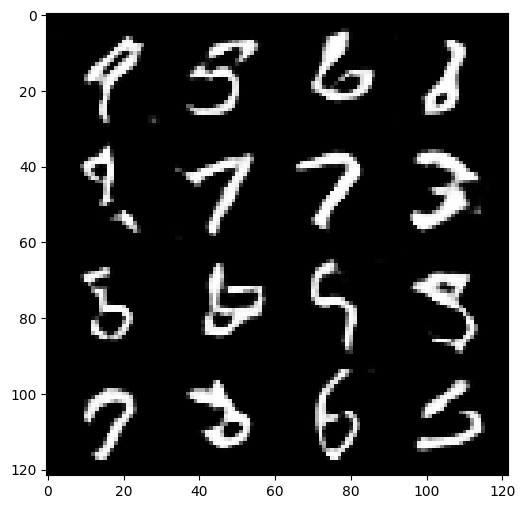

In [24]:
# Generate some images
noise = torch.randn(16, latent_dim).to(device)
generated_images = generator(noise).view(-1, 1, 28, 28).cpu().detach()
grid = make_grid(generated_images, nrow=4, normalize=True)

plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.show()

In [25]:
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")
